In [1]:
# import libraries 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
#import racplusplus
import pickle
from scipy.cluster import hierarchy
import math

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

my_colors_2 = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#cd5a61', '#343934', '#c91e29','#64a0e0', '#913d27', 
               '#F46036', '#5386E4',  '#bea602', '#0a6682', '#215463']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

In [3]:
# import clean data set

df_wind = pd.read_csv('../../../data_analysis_and_preproc/intermediate/wind/final_wind_df.csv')

In [4]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1


In [5]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5379910 entries, 0 to 5379909
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   asset_id              int64  
 1   read_at               object 
 2   wind_speed            float64
 3   wind_direction        float64
 4   power_average         float64
 5   rotation_average      float64
 6   exterior_temperature  float64
 7   nacelle_temperature   float64
 8   farm                  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 369.4+ MB


In [6]:
# df_wind["asset_id"] = df_wind["asset_id"].astype("category")
# df_wind["farm"] = df_wind["farm"].astype("category")

In [7]:
# cols_int = ["wind_direction", "power_average", "exterior_temperature", "nacelle_temperature"]
# df_wind[cols_int] = df_wind[cols_int].astype("int8")

# cols_float = ["wind_speed", "rotation_average"]
# df_wind[cols_float] = df_wind[cols_float].astype("float16")

In [8]:
df_wind["read_at"] = pd.to_datetime(df_wind["read_at"]).map(pd.Timestamp.timestamp)

In [9]:
df_wind["read_at"] = df_wind["read_at"].astype("uint32")
df_wind["read_at"]

0          1609459200
1          1609460400
2          1609474800
3          1609510800
4          1609512000
              ...    
5379905    1680169800
5379906    1680170400
5379907    1680171000
5379908    1680171600
5379909    1680172200
Name: read_at, Length: 5379910, dtype: uint32

In [10]:
#df_wind[cols_float+cols_int + ["read_at"]].info()

In [11]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1609459200,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,1609460400,8.1,298.0,666.0,14.88,-2.0,10.0,1
2,11,1609474800,5.1,297.0,137.0,9.45,-3.0,10.0,1
3,11,1609510800,7.8,301.0,614.0,14.51,-2.0,11.0,1
4,11,1609512000,7.7,301.0,611.0,14.60,-2.0,10.0,1


In [12]:
np.random.seed(10)

asset = df_wind['asset_id'].unique()[0]

length = len(df_wind[df_wind['asset_id'] == asset])

subset_size = int(0.01 * length)  # Adjust the percentage as needed

# Group the DataFrame by the asset identifier column(s)
grouped = df_wind.groupby('asset_id')

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each group, sample subset_size rows from each group, and append to subset_data
for _, group_df in grouped:
    sampled_group = group_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all groups into a single DataFrame
df_subset = pd.concat(subset_data)

In [13]:
df_subset = df_subset.reset_index(drop=True)

In [14]:
n_components = 2
pca = PCA(n_components=n_components)

In [15]:
df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1640040600,8.7,177.0,909.0,16.08,7.0,12.0,1
1,11,1632084600,2.7,-80.0,20.0,6.66,11.0,27.0,1
2,11,1653139200,6.2,-240.0,451.0,13.60,22.0,30.0,1
3,11,1643802000,9.1,114.0,1250.0,16.55,10.0,13.0,1
4,11,1660968600,5.3,-237.0,186.0,10.44,22.0,34.0,1


In [16]:
X = df_subset.iloc[:,1:-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_pca = pca.fit_transform(X_scaled)

In [17]:
# len(df_subset[df_subset['asset_id']==11])

In [18]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [19]:
X_scaled.head()

,0,1,2,3,4,5,6
0,-0.238071,0.748283,0.599444,0.451986,1.141806,-0.779048,-1.230358
1,-0.629206,-1.251080,-0.661702,-0.908794,-1.373640,-0.203777,0.705770
2,0.405887,-0.084785,-1.446851,-0.249068,0.479566,1.378218,1.092996
3,-0.053152,0.881574,0.290291,0.973950,1.267311,-0.347595,-1.101283
4,0.790798,-0.384689,-1.432129,-0.654700,-0.364257,1.378218,1.609297


In [20]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44801 entries, 0 to 44800
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       44801 non-null  float64
 1   1       44801 non-null  float64
 2   2       44801 non-null  float64
 3   3       44801 non-null  float64
 4   4       44801 non-null  float64
 5   5       44801 non-null  float64
 6   6       44801 non-null  float64
dtypes: float64(7)
memory usage: 2.4 MB


In [21]:
X_scaled = X_scaled.astype('float16')
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44801 entries, 0 to 44800
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       44801 non-null  float16
 1   1       44801 non-null  float16
 2   2       44801 non-null  float16
 3   3       44801 non-null  float16
 4   4       44801 non-null  float16
 5   5       44801 non-null  float16
 6   6       44801 non-null  float16
dtypes: float16(7)
memory usage: 612.6 KB


# Hierarchical clustering

## Aglomerative

### Single Link

In [53]:
# Fit Agglomerative Clustering model on the combined data
model_single = AgglomerativeClustering(linkage= 'single',distance_threshold=0.5, n_clusters=None)
model_single.fit(np.array(X_scaled))

AgglomerativeClustering(distance_threshold=0.5, linkage='single',
                        n_clusters=None)

In [19]:
with open('results/hierarchical/single_clustering.pickle', 'rb') as f:
    model_single = pickle.load(f)

In [20]:
model_single.n_clusters_

38586

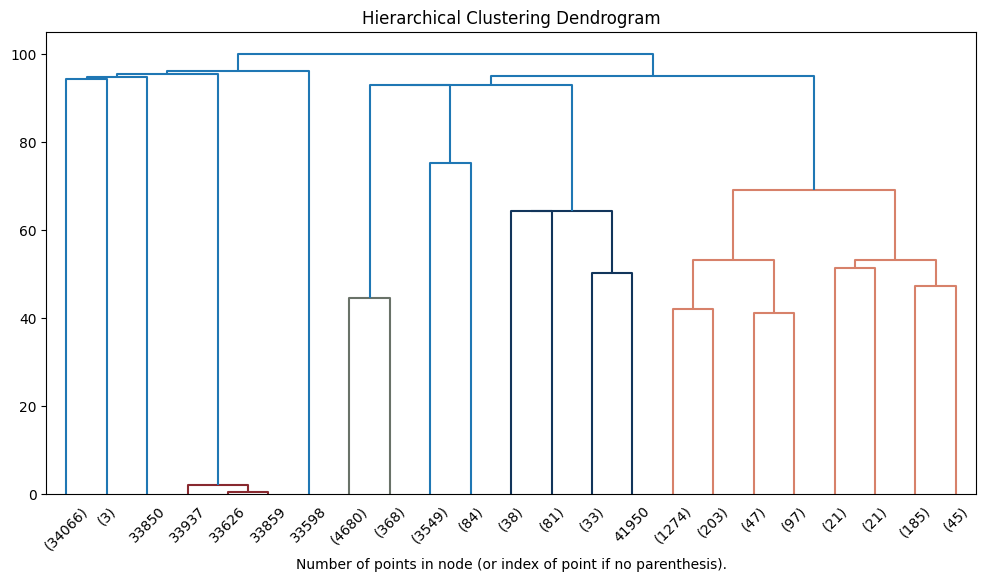

In [56]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_single, truncate_mode='level', p = 4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [22]:
# Cut dendrogram to obtain labels
num_clusters = 71  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_single.children_, model_single.distances_,
                                  np.ones_like(model_single.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[ 1  1  1 ... 68 68 68]


In [ ]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])
df_wind = df_wind.drop(columns=['cluster_label'])

In [24]:
# Assign the cluster labels to the original DataFrame
X_scaled['cluster_label'] = labels_cut
X_scaled['asset_id'] = df_subset['asset_id']

In [25]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.3,296.0,802.0,15.51,-2.0,9.0,1,1
1,11,1609460400,8.1,298.0,666.0,14.88,-2.0,10.0,1,1
2,11,1609474800,5.1,297.0,137.0,9.45,-3.0,10.0,1,1
3,11,1609510800,7.8,301.0,614.0,14.51,-2.0,11.0,1,1
4,11,1609512000,7.7,301.0,611.0,14.60,-2.0,10.0,1,1


In [26]:
len(most_frequent_clusters.unique())

5

In [27]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.30,296.00,802.00,15.51,-2.00,9.00,1,1
1,12,1609459800,8.50,314.00,832.00,15.54,-1.00,12.00,1,1
2,13,1609459200,8.10,-49.00,749.00,15.23,-2.00,5.00,1,1
3,14,1609459200,8.60,-38.00,925.00,15.96,-1.00,15.00,1,1
4,15,1609459200,8.80,-47.00,998.00,16.11,-2.00,7.00,1,1
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.70,-362.00,62.00,7.75,7.00,15.00,4,56
67,415,1609459200,4.50,285.00,128.00,9.39,2.00,11.00,4,56
68,510,1609459200,8.45,306.80,1329.78,13.81,1.21,8.06,5,68
69,511,1609459200,8.32,301.15,1310.88,13.66,3.46,10.68,5,68


/tmp/ipykernel_40301/1167155771.py:21: UserWarning: The palette list has more values (17) than needed (5), which may not be intended.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)


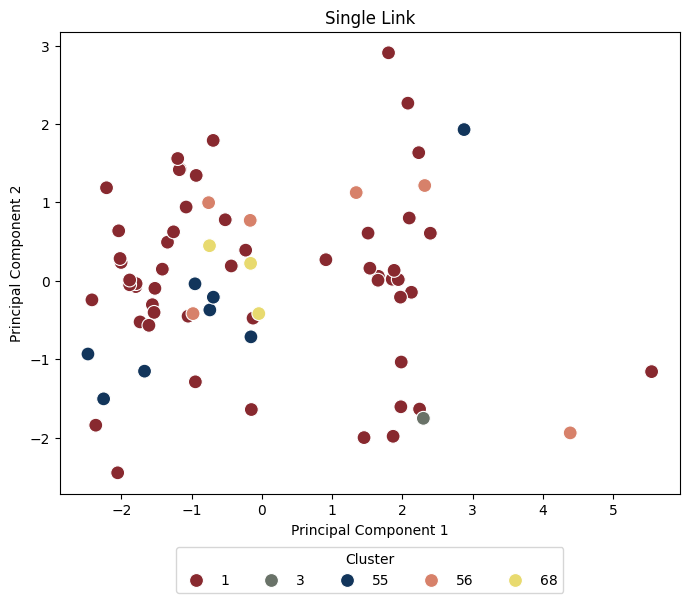

In [28]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

color_palette = sns.color_palette(my_colors_2)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title('Single Link')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [65]:
with open('results/hierarchical/single_clustering.pickle', 'wb') as f:
    pickle.dump(model_single, f)

In [66]:
df_wind.to_csv('results/hierarchical/single_link.csv')

In [31]:
df_wind = df_wind.drop(columns='cluster_label')

In [32]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])

### Average Link

In [20]:
model_average = AgglomerativeClustering(linkage='average', distance_threshold=0.5, n_clusters=None)
model_average.fit(np.array(X_scaled))

AgglomerativeClustering(distance_threshold=0.5, linkage='average',
                        n_clusters=None)

In [29]:
with open('results/hierarchical/average_clustering.pickle', 'rb') as f:
    model_average = pickle.load(f)

In [30]:
# Cut dendrogram to obtain labels
num_clusters = 71  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_average.children_, model_average.distances_,
                                  np.ones_like(model_average.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[51 34 13 ... 18 59 15]


In [33]:
# Assign the cluster labels to the original DataFrame
X_scaled['cluster_label'] = labels_cut

In [34]:
X_scaled['asset_id'] = df_subset['asset_id']

In [35]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()



,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.3,296.0,802.0,15.51,-2.0,9.0,1,34
1,11,1609460400,8.1,298.0,666.0,14.88,-2.0,10.0,1,34
2,11,1609474800,5.1,297.0,137.0,9.45,-3.0,10.0,1,34
3,11,1609510800,7.8,301.0,614.0,14.51,-2.0,11.0,1,34
4,11,1609512000,7.7,301.0,611.0,14.60,-2.0,10.0,1,34


In [36]:
len(most_frequent_clusters.unique())

12

In [37]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.30,296.00,802.00,15.51,-2.00,9.00,1,34
1,12,1609459800,8.50,314.00,832.00,15.54,-1.00,12.00,1,34
2,13,1609459200,8.10,-49.00,749.00,15.23,-2.00,5.00,1,20
3,14,1609459200,8.60,-38.00,925.00,15.96,-1.00,15.00,1,34
4,15,1609459200,8.80,-47.00,998.00,16.11,-2.00,7.00,1,34
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.70,-362.00,62.00,7.75,7.00,15.00,4,15
67,415,1609459200,4.50,285.00,128.00,9.39,2.00,11.00,4,34
68,510,1609459200,8.45,306.80,1329.78,13.81,1.21,8.06,5,32
69,511,1609459200,8.32,301.15,1310.88,13.66,3.46,10.68,5,15


/tmp/ipykernel_40301/4154262498.py:21: UserWarning: The palette list has more values (17) than needed (12), which may not be intended.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)


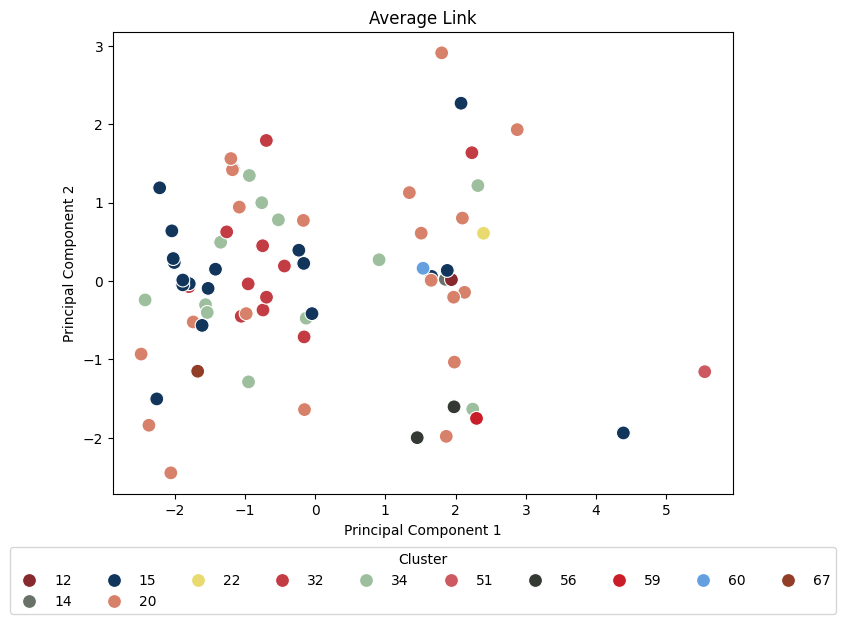

In [38]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

color_palette = sns.color_palette(my_colors_2)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title('Average Link')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [33]:
with open('results/hierarchical/average_clustering.pickle', 'wb') as f:
    pickle.dump(model_average, f)

In [35]:
df_wind.to_csv('results/hierarchical/average_link.csv')

In [41]:
df_wind = df_wind.drop(columns='cluster_label')

In [42]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])

### Ward's method

In [38]:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=0.5, n_clusters=None)
model_ward.fit(np.array(X_scaled))

AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)

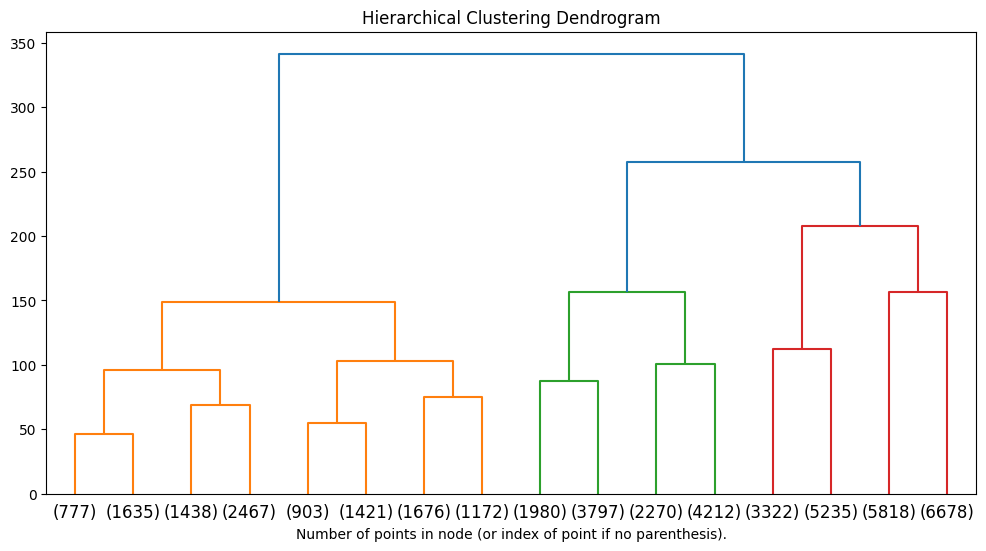

In [39]:
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_ward, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [40]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1609459200,8.296875,40,34,15.507812,-2,9,1
1,11,1609460400,8.101562,42,-102,14.882812,-2,10,1
2,11,1609474800,5.101562,41,-119,9.453125,-3,10,1
3,11,1609510800,7.800781,45,102,14.507812,-2,11,1
4,11,1609512000,7.699219,45,99,14.601562,-2,10,1


In [41]:
X_scaled

,0,1,2,3,4,5,6
0,-0.238071,0.749315,-1.260556,-1.744834,1.141314,-0.767843,-1.218057
1,-0.629206,-1.251346,-1.275438,0.189118,-1.373583,-0.191942,0.716077
2,0.405887,-0.085054,0.153188,-0.971253,0.479993,1.391785,1.102904
3,-0.053152,0.882084,1.611577,-0.527161,1.266485,-0.335917,-1.089115
4,0.790798,-0.384437,0.197833,-1.100183,-0.364912,1.391785,1.618673
...,...,...,...,...,...,...,...
44796,-0.853829,-0.861497,1.299066,0.819443,-1.152447,1.391785,0.587135
44797,1.637049,0.941961,-0.427191,0.833769,0.555096,-0.767843,-1.089115
44798,1.560001,-0.234745,0.882383,-0.656091,-0.337792,-0.911818,-0.831230
44799,-0.317596,1.241344,1.284184,0.948373,0.569699,-1.343744,-1.475941


In [127]:
X_scaled = X_scaled.drop(columns='cluster_label')

In [39]:
with open('results/hierarchical/ward_clustering.pickle', 'rb') as f:
    model_ward = pickle.load(f)

In [40]:
# Cut dendrogram to obtain labels
num_clusters = 71/3  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_ward.children_, model_ward.distances_,
                                  np.ones_like(model_ward.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[19 15 12 ... 20  5 19]


In [43]:
# Assign the cluster labels to the original DataFrame
X_scaled['cluster_label'] = labels_cut

In [44]:
X_scaled['asset_id'] = df_subset['asset_id']

In [45]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.3,296.0,802.0,15.51,-2.0,9.0,1,15
1,11,1609460400,8.1,298.0,666.0,14.88,-2.0,10.0,1,15
2,11,1609474800,5.1,297.0,137.0,9.45,-3.0,10.0,1,15
3,11,1609510800,7.8,301.0,614.0,14.51,-2.0,11.0,1,15
4,11,1609512000,7.7,301.0,611.0,14.60,-2.0,10.0,1,15


In [46]:
len(most_frequent_clusters.unique())

12

In [47]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.30,296.00,802.00,15.51,-2.00,9.00,1,15
1,12,1609459800,8.50,314.00,832.00,15.54,-1.00,12.00,1,18
2,13,1609459200,8.10,-49.00,749.00,15.23,-2.00,5.00,1,21
3,14,1609459200,8.60,-38.00,925.00,15.96,-1.00,15.00,1,20
4,15,1609459200,8.80,-47.00,998.00,16.11,-2.00,7.00,1,18
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.70,-362.00,62.00,7.75,7.00,15.00,4,18
67,415,1609459200,4.50,285.00,128.00,9.39,2.00,11.00,4,18
68,510,1609459200,8.45,306.80,1329.78,13.81,1.21,8.06,5,20
69,511,1609459200,8.32,301.15,1310.88,13.66,3.46,10.68,5,20


/tmp/ipykernel_40301/2185764408.py:21: UserWarning: The palette list has more values (17) than needed (12), which may not be intended.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)


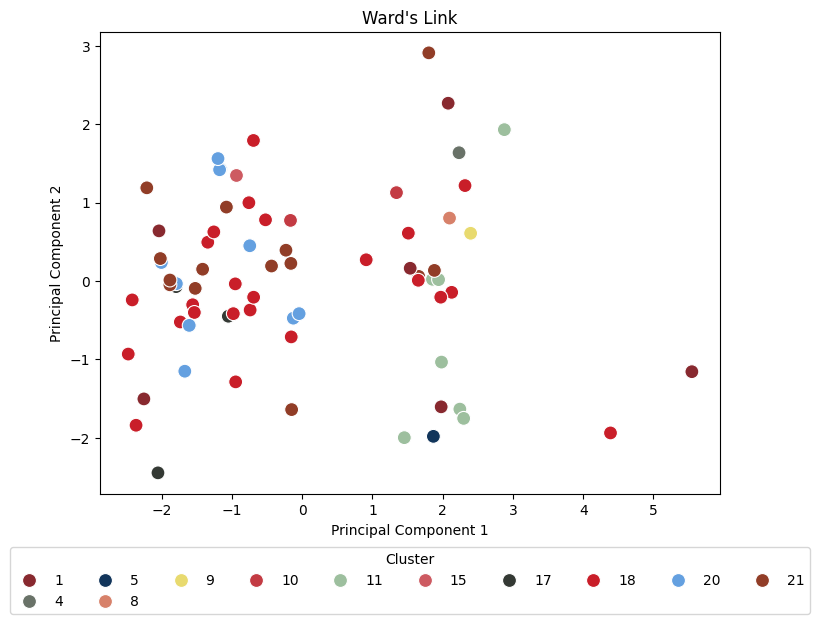

In [48]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

color_palette = sns.color_palette(my_colors_2)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title("Ward's Link")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [63]:
with open('results/hierarchical/ward_clustering.pickle', 'wb') as f:
    pickle.dump(model_ward, f)

In [64]:
df_wind.to_csv('results/hierarchical/ward_link.csv')

In [49]:
df_wind = df_wind.drop(columns='cluster_label')

In [35]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])

## Centroid Linkage

In [36]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def centroid(cluster):
    return np.mean(cluster, axis=0)

def centroid_linkage_clustering(data):
    # Initialize each data point as its own cluster along with their original indices
    clusters = [({'label': i, 'points': [point]}, [i]) for i, point in enumerate(data)]
    cluster_labels = list(range(len(data)))  # Initial cluster labels for each data point

    while len(clusters) > 1:
        # Calculate centroids for each cluster
        centroids = [centroid(cluster[0]['points']) for cluster in clusters]

        min_distance = float('inf')
        merge_indices = None

        # Find the closest pair of clusters based on centroid distance
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                distance = euclidean_distance(centroids[i], centroids[j])
                if distance < min_distance:
                    min_distance = distance
                    merge_indices = (i, j)

        # Merge the closest clusters
        merged_cluster = (clusters[merge_indices[0]][0]['points'] + clusters[merge_indices[1]][0]['points'], 
                          clusters[merge_indices[0]][1] + clusters[merge_indices[1]][1])
        
        # Update cluster labels for merged points
        for idx in merged_cluster[1]:
            cluster_labels[idx] = len(clusters)

        del clusters[merge_indices[1]]
        del clusters[merge_indices[0]]

        clusters.append(({'points': merged_cluster[0]}, merged_cluster[1]))  # Update merged cluster tuple

    return merged_cluster, cluster_labels

# Example usage
merged_cluster, cluster_labels = centroid_linkage_clustering(X_scaled)

# Add cluster labels to the DataFrame
X_scaled['cluster_label'] = cluster_labels

X_scaled.head()


,0,1,2,3,4,5,6,cluster_label
0,-0.238037,0.748047,0.599609,0.451904,1.141602,-0.778809,-1.230469,2
1,-0.629395,-1.250977,-0.661621,-0.908691,-1.374023,-0.203735,0.705566,2
2,0.406006,-0.084778,-1.447266,-0.249023,0.479492,1.377930,1.092773,2
3,-0.053162,0.881348,0.290283,0.974121,1.267578,-0.347656,-1.101562,2
4,0.791016,-0.384766,-1.432617,-0.654785,-0.364258,1.377930,1.609375,2


In [37]:
X_scaled['asset_id'] = df_subset['asset_id']

In [39]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.3,296.0,802.0,15.51,-2.0,9.0,1,2
1,11,1609460400,8.1,298.0,666.0,14.88,-2.0,10.0,1,2
2,11,1609474800,5.1,297.0,137.0,9.45,-3.0,10.0,1,2
3,11,1609510800,7.8,301.0,614.0,14.51,-2.0,11.0,1,2
4,11,1609512000,7.7,301.0,611.0,14.60,-2.0,10.0,1,2


In [40]:
len(most_frequent_clusters.unique())

71

In [41]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.30,296.00,802.00,15.51,-2.00,9.00,1,2
1,12,1609459800,8.50,314.00,832.00,15.54,-1.00,12.00,1,631
2,13,1609459200,8.10,-49.00,749.00,15.23,-2.00,5.00,1,1262
3,14,1609459200,8.60,-38.00,925.00,15.96,-1.00,15.00,1,1893
4,15,1609459200,8.80,-47.00,998.00,16.11,-2.00,7.00,1,2524
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.70,-362.00,62.00,7.75,7.00,15.00,4,41646
67,415,1609459200,4.50,285.00,128.00,9.39,2.00,11.00,4,42277
68,510,1609459200,8.45,306.80,1329.78,13.81,1.21,8.06,5,42908
69,511,1609459200,8.32,301.15,1310.88,13.66,3.46,10.68,5,43539


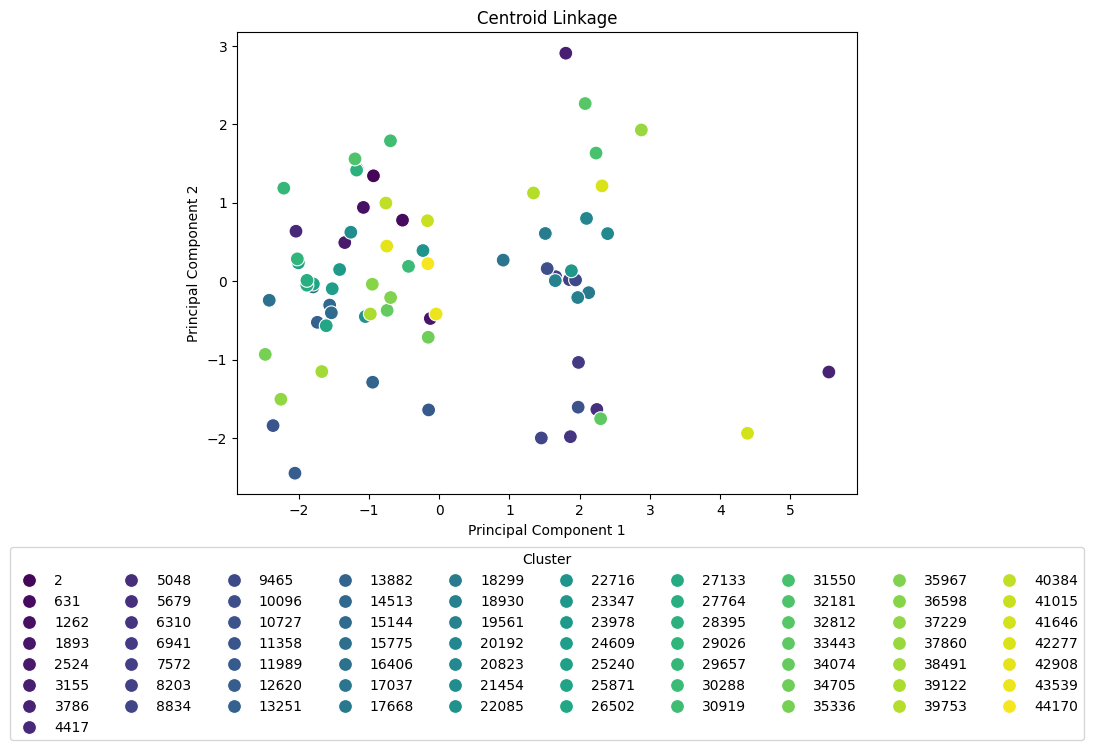

In [44]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

num_clusters = len(pca_df['cluster_label'])
color_palette = sns.color_palette('viridis', num_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title("Centroid Linkage")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [46]:
df_wind.to_csv('results/hierarchical/centroid_link.csv')

In [47]:
df_wind = df_wind.drop(columns='cluster_label')

In [48]:
X_scaled = X_scaled.drop(columns=['cluster_label', 'asset_id'])

### BIRCH

In [22]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=None)
brc.fit_predict(X_scaled)


array([  37, 2724, 2042, ...,  454, 1397, 2416])

In [76]:
from scipy.spatial.distance import pdist, squareform


# Compute pairwise distances between data points
distance_matrix_condensed = pdist(X_scaled)
distance_matrix = squareform(distance_matrix_condensed)

# Create dendrogram
dendrogram(distance_matrix, truncate_mode='level', p=3)
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


: 

In [23]:
X_scaled['cluster_label'] = brc.labels_
X_scaled['asset_id'] = df_subset['asset_id']
X_scaled.head()

,0,1,2,3,4,5,6,cluster_label,asset_id
0,-0.238037,0.748047,0.599609,0.451904,1.141602,-0.778809,-1.230469,37,11
1,-0.629395,-1.250977,-0.661621,-0.908691,-1.374023,-0.203735,0.705566,2724,11
2,0.406006,-0.084778,-1.447266,-0.249023,0.479492,1.377930,1.092773,2042,11
3,-0.053162,0.881348,0.290283,0.974121,1.267578,-0.347656,-1.101562,1081,11
4,0.791016,-0.384766,-1.432617,-0.654785,-0.364258,1.377930,1.609375,2191,11


In [27]:
# Assign the cluster labels to the original DataFrame
X_scaled['cluster_label'] = brc.labels_

In [28]:
X_scaled['asset_id'] = df_subset['asset_id']

In [29]:
most_frequent_clusters = X_scaled.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
#df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.3,296.0,802.0,15.51,-2.0,9.0,1,535
1,11,1609460400,8.1,298.0,666.0,14.88,-2.0,10.0,1,535
2,11,1609474800,5.1,297.0,137.0,9.45,-3.0,10.0,1,535
3,11,1609510800,7.8,301.0,614.0,14.51,-2.0,11.0,1,535
4,11,1609512000,7.7,301.0,611.0,14.60,-2.0,10.0,1,535


In [30]:
len(most_frequent_clusters.unique())

62

In [31]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1609459200,8.30,296.00,802.00,15.51,-2.00,9.00,1,535
1,12,1609459800,8.50,314.00,832.00,15.54,-1.00,12.00,1,821
2,13,1609459200,8.10,-49.00,749.00,15.23,-2.00,5.00,1,368
3,14,1609459200,8.60,-38.00,925.00,15.96,-1.00,15.00,1,2692
4,15,1609459200,8.80,-47.00,998.00,16.11,-2.00,7.00,1,2464
...,...,...,...,...,...,...,...,...,...,...
66,414,1609599600,3.70,-362.00,62.00,7.75,7.00,15.00,4,176
67,415,1609459200,4.50,285.00,128.00,9.39,2.00,11.00,4,2850
68,510,1609459200,8.45,306.80,1329.78,13.81,1.21,8.06,5,771
69,511,1609459200,8.32,301.15,1310.88,13.66,3.46,10.68,5,1107


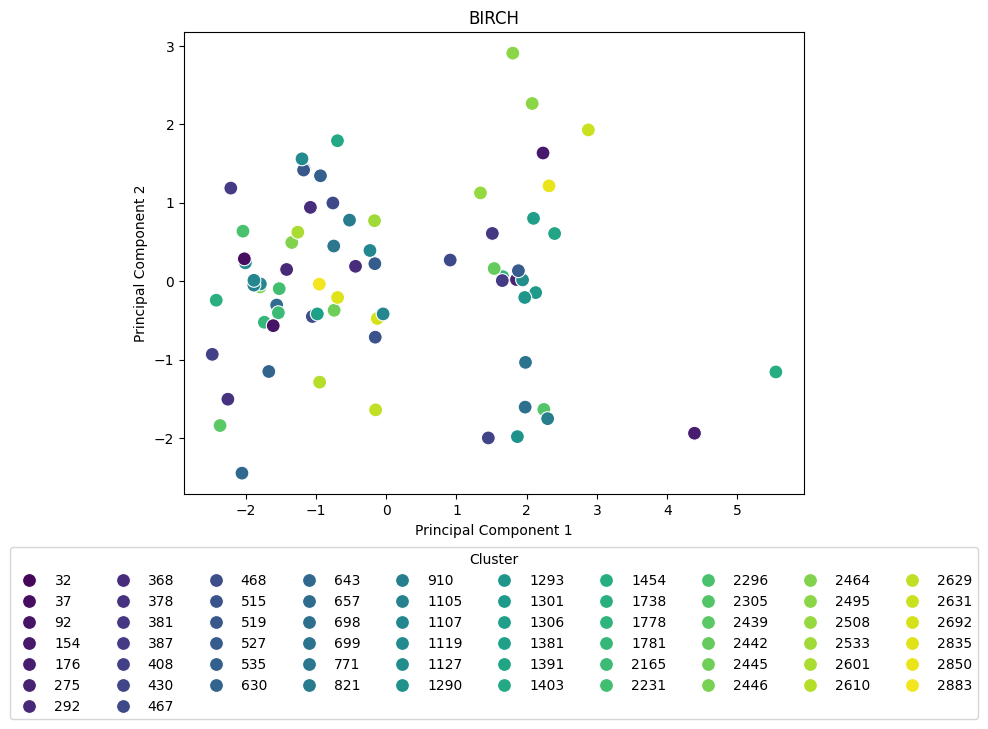

In [48]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster_label'] = representative_points['cluster_label']

num_clusters = len(pca_df['cluster_label'].unique())
color_palette = sns.color_palette('viridis', num_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=color_palette, s=100)
plt.title("BIRCH")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)
plt.show()

In [36]:
assets_clusters = df_wind.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 32: [19]
Cluster 37: [111]
Cluster 92: [57]
Cluster 154: [115]
Cluster 176: [414]
Cluster 275: [25]
Cluster 292: [53]
Cluster 368: [13, 113]
Cluster 378: [315]
Cluster 381: [43]
Cluster 387: [45, 112]
Cluster 408: [312]
Cluster 430: [26]
Cluster 467: [41, 412]
Cluster 468: [49]
Cluster 515: [311]
Cluster 519: [110]
Cluster 527: [52, 512]
Cluster 535: [11]
Cluster 630: [317]
Cluster 643: [33]
Cluster 657: [36]
Cluster 698: [29]
Cluster 699: [23]
Cluster 771: [510]
Cluster 821: [12]
Cluster 910: [210]
Cluster 1105: [58]
Cluster 1107: [51, 55, 56, 59, 511]
Cluster 1119: [116]
Cluster 1127: [27]
Cluster 1290: [22]
Cluster 1293: [44]
Cluster 1301: [42]
Cluster 1306: [46]
Cluster 1381: [410]
Cluster 1391: [47]
Cluster 1403: [114]
Cluster 1454: [17]
Cluster 1738: [39]
Cluster 1778: [24]
Cluster 1781: [34]
Cluster 2165: [37]
Cluster 2231: [54]
Cluster 2296: [18]
Cluster 2305: [21]
Cluster 2439: [31]
Cluster 2442: [28]
Cluster 2445: [310]
Cluster 2446: [38]
Cluster 2464: [15]
Cluster 24

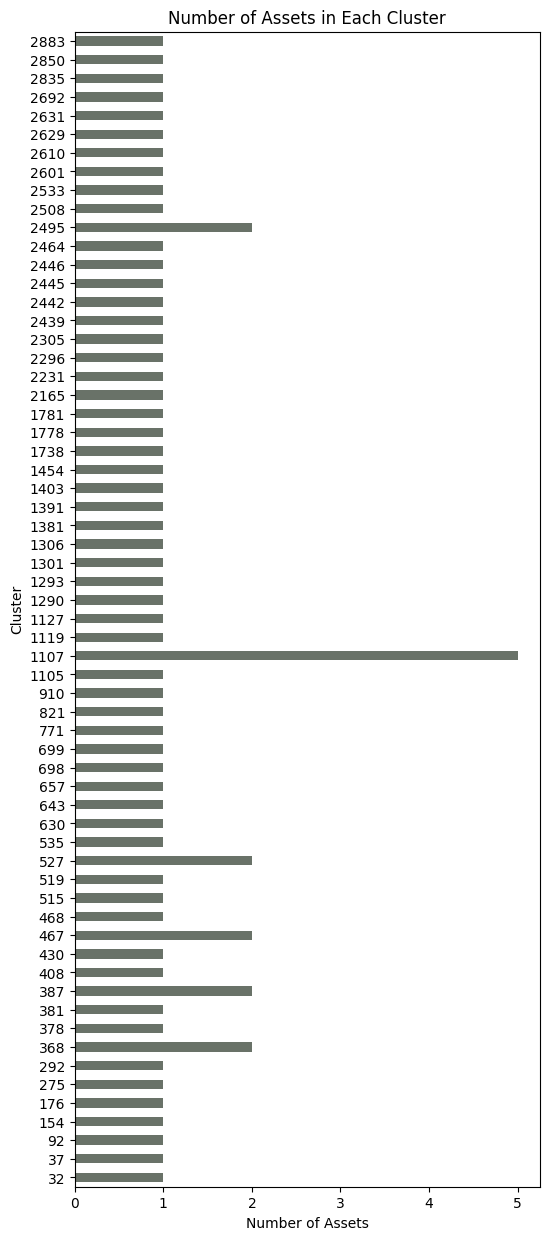

In [45]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 15))
cluster_counts.plot(kind='barh', color=my_colors[1])
plt.xlabel('Number of Assets')
plt.ylabel('Cluster')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [46]:
with open('results/hierarchical/birch_clustering.pickle', 'wb') as f:
    pickle.dump(brc, f)

In [47]:
df_wind.to_csv('results/hierarchical/birch.csv')